In [2]:
!pip install spacy evaluate seqeval

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 775.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=25855ad790ab9278c9c1c45e5b669807b7e54a5dd579f0e1e292a5eb54c1c8f9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
!python -m spacy download uk_core_news_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 65.1 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for pymorphy3>=1.0.0 from https://files.pythonhosted.org/packages/4a/cb/93e0c48d81e341abe615c433411ce5706dda1e0ba2281b91158a17e4ada1/pymorphy3-1.3.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 70.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')


In [4]:
!pip install --upgrade sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 6.1 MB/s eta 0:00:00a 0:00:01


In [31]:
import re
import os
import numpy as np
import pandas as pd
import torch
import pycrfsuite
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import ipywidgets as widgets
import spacy
import math
import gc
import nltk
import string


from sklearn.model_selection import StratifiedKFold
from sklearn_crfsuite import metrics
from typing import List, Tuple
from pprint import pprint
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from itertools import chain
from torch import nn
from copy import deepcopy
from nltk import tokenize
from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, \
    AdamW, get_linear_schedule_with_warmup, Trainer,\
    pipeline
import evaluate
from shutil import rmtree
import warnings
warnings.filterwarnings("ignore")

np.random.seed(98)

In [6]:
INPUT_FOLDER_PATH = '/kaggle/input/nlp-ua-locations-extractions'
WORKING_FOLDER_PATH = '/kaggle/working'

UK_FILE_PATH = INPUT_FOLDER_PATH + "/uk_geo_dataset.csv"
ru_FILE_PATH = INPUT_FOLDER_PATH + "/ru_geo_dataset.csv"
TEST_FILE_PATH = INPUT_FOLDER_PATH + "/test.csv"
TEST_SAMPLE_FILE_PATH = INPUT_FOLDER_PATH + "/labeling_sample.csv"

UKR_TRAIN_FRACTION = 0.15
UKR_TEST_FRACTION = 0.3

LABEL2ID = {'O': 0, 'B-LOC': 1, 'I-LOC': 2, 'B-ORG':3, 'I-ORG': 4, 'B-PER': 5, 'I-PER': 6}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

In [7]:
uk_geo_dataset = pd.read_csv(UK_FILE_PATH, converters={"loc_markers": eval, 'org_markers': eval, 'per_markers': eval})
ru_geo_dataset = pd.read_csv(ru_FILE_PATH, converters={"loc_markers": eval, 'org_markers': eval, 'per_markers': eval})

test_sample_dataset = pd.read_csv(TEST_SAMPLE_FILE_PATH, converters={"loc_markers": eval, "locations": eval})
test_dataset = pd.read_csv(TEST_FILE_PATH, converters={"locations": eval}, index_col="text_id")

In [8]:
def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

<a id="data-preparation"></a>
## Data preparation

In [9]:
russian_docs = ru_geo_dataset.loc[:, 'doc_id'].unique().astype(int)

test_ru_docs = np.random.choice(russian_docs, 200)
test_ru_docs[:20]

array([384474, 647757, 216244, 560597, 280641,  56004, 307271,  58857,
       566061, 450564, 479052, 529309, 684479, 134106, 160463, 118759,
       683777, 300806,    340, 561375])

In [10]:
ru_geo_dataset.loc[:, "is_valid"] = 0
ru_geo_dataset.loc[ru_geo_dataset['doc_id'].isin(test_ru_docs), "is_valid"] = 1

In [11]:
TEST_PROPORTION_RU = 0.09

In [12]:
df_ukr_train = uk_geo_dataset[~uk_geo_dataset.is_valid.astype(bool)].sample(frac=UKR_TRAIN_FRACTION)
df_ukr_valid = uk_geo_dataset[uk_geo_dataset.is_valid.astype(bool)].sample(frac=UKR_TEST_FRACTION)
df_ukr_locations = pd.concat([df_ukr_train, df_ukr_valid], axis=0)

df_ru_train = ru_geo_dataset[~ru_geo_dataset.is_valid.astype(bool)].sample(n=int(TEST_PROPORTION_RU*len(df_ukr_train)))
df_ru_valid = ru_geo_dataset[ru_geo_dataset.is_valid.astype(bool)].sample(n=int(TEST_PROPORTION_RU*len(df_ukr_valid)))
df_ru_locations = pd.concat([df_ru_train, df_ru_valid], axis=0)

In [13]:
print(f"Ukrainian docs:\n- {len(df_ukr_locations)} total sentences;\n- {(df_ukr_locations.is_valid == 1).sum()} test sentences")
print(f"russian docs:\n- {len(df_ru_locations)} total sentences;\n- {(df_ru_locations.is_valid == 1).sum()} test sentences")

Ukrainian docs:
- 153000 total sentences;
- 3000 test sentences
russian docs:
- 13770 total sentences;
- 270 test sentences


In [14]:
df_ukr_locations.loc_markers = df_ukr_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in x])
df_ukr_locations.org_markers = df_ukr_locations.org_markers.apply(lambda x: [[y[0], y[1], 'ORG']  for y in x])
df_ukr_locations.per_markers = df_ukr_locations.per_markers.apply(lambda x: [[y[0], y[1], 'PER']  for y in x])

df_ru_locations.loc_markers = df_ru_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in x])
df_ru_locations.org_markers = df_ru_locations.org_markers.apply(lambda x: [[y[0], y[1], 'ORG']  for y in x])
df_ru_locations.per_markers = df_ru_locations.per_markers.apply(lambda x: [[y[0], y[1], 'PER']  for y in x])

In [15]:
nlp = spacy.blank("xx")

def convert_to_conll(row, test=False, text_col = 'text'):
    data = {
        "text": row[text_col]
    }
    doc = nlp(data["text"])
    if test:
        return list([t.text for t in doc])
    
    labels_candidates = sorted(row['loc_markers'] + row['org_markers'] + row['per_markers'])
    data['label'] = []
    for i, (start, end, label) in enumerate(labels_candidates):
        if i > 0:
            if data['label'][-1][1] > start:
                continue
                
        data['label'].append([start, end, label])
    
    ents = []
    for start, end, label in data["label"]:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
        else:
            chosen = [w for i, w in enumerate(doc) if (w.idx > start) and (w.idx + len(w.text) < end)]
            if len(chosen) == 0:
                continue
            span_start = chosen[0].idx
            span_end = chosen[-1].idx + len(chosen[-1].text)
            corrected_span = doc.char_span(span_start, span_end, label=label)
            if corrected_span is not None:
                ents.append(corrected_span)
            else:
                print(
                    "Skipping corrected span (does not align to tokens):",
                    start,
                    end,
                    label,
                    doc.text[start:end],
                )
    try:
        doc.ents = ents
    except ValueError as e:
        print(data['label'])
        print(ents)
        
        raise e
    return pd.Series({
        'conll_tokens': list([t.text for t in doc]),
        'conll_labels': list(biluo_to_iob(doc_to_biluo_tags(doc)))
    })

In [16]:
df_ukr_locations.loc[:, ["conll_tokens", "conll_labels"]] = df_ukr_locations.progress_apply(convert_to_conll, axis=1)
df_ru_locations.loc[:, ["conll_tokens", "conll_labels"]] = df_ru_locations.progress_apply(convert_to_conll, axis=1)

  0%|          | 0/153000 [00:00<?, ?it/s]

  0%|          | 0/13770 [00:00<?, ?it/s]

In [17]:
df_ukr_locations, df_ukr_locations_holdout_test = df_ukr_locations[df_ukr_locations["is_valid"] == 0].reset_index(drop=True), df_ukr_locations[df_ukr_locations["is_valid"] == 1].reset_index(drop=True)
df_ru_locations, df_ru_locations_holdout_test = df_ru_locations[df_ru_locations["is_valid"] == 0].reset_index(drop=True), df_ru_locations[df_ru_locations["is_valid"] == 1].reset_index(drop=True)
df_holdout_test = pd.concat([df_ukr_locations_holdout_test, df_ru_locations_holdout_test], axis=0)

In [18]:
df_ukr_locations["stratify_col"] = df_ukr_locations["loc_markers"].apply(len)
df_ukr_locations.loc[df_ukr_locations["stratify_col"] >= 10, "stratify_col"] = -1
df_ukr_locations["stratify_col"].value_counts()

stratify_col
 0    115274
 1     24029
 2      7156
 3      2226
 4       741
 5       294
 6       136
 7        56
 8        39
 9        25
-1        24
Name: count, dtype: int64

In [19]:
skf_ukr = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids_ukr = [el for el in skf_ukr.split(df_ukr_locations, df_ukr_locations["stratify_col"])]

ukr_locations_train_ids, ukr_locations_val_ids = folds_train_test_ids_ukr[0]
df_ukr_locations_train = df_ukr_locations.loc[ukr_locations_train_ids]
df_ukr_locations_val = df_ukr_locations.loc[ukr_locations_val_ids]

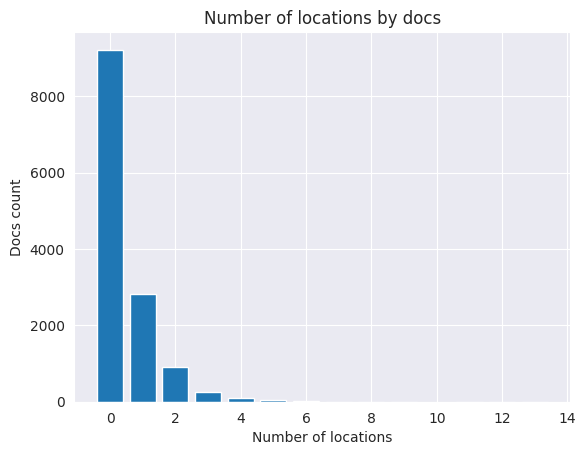

In [20]:
df_ru_locations.loc[:, "number_of_locations"] = df_ru_locations["loc_markers"].apply(len)

docs_ru_locs_counts = df_ru_locations.groupby('doc_id').agg({'number_of_locations': 'sum'})

docs_ru_locs_counts_freqs = docs_ru_locs_counts['number_of_locations'].value_counts()

plt.bar(docs_ru_locs_counts_freqs.keys(), docs_ru_locs_counts_freqs.values)
plt.title("Number of locations by docs")
plt.ylabel("Docs count")
plt.xlabel("Number of locations")
plt.show()

In [21]:
min_cocs_ru_freqs = min(docs_ru_locs_counts_freqs[docs_ru_locs_counts_freqs.values < 10].keys())
min_cocs_ru_freqs

7

In [22]:
df_ru_locations.loc[:, "stratify_col"] = docs_ru_locs_counts.loc[df_ru_locations.loc[:, 'doc_id']].values
df_ru_locations.loc[df_ru_locations.loc[:, "stratify_col"] >= min_cocs_ru_freqs, "stratify_col"] = -1

In [23]:
skf_ru = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids_ru = [el for el in skf_ru.split(df_ru_locations, df_ru_locations["stratify_col"])]

ru_locations_train_ids, ru_locations_val_ids = folds_train_test_ids_ru[0]
df_ru_locations_train = df_ru_locations.loc[ru_locations_train_ids]
df_ru_locations_val = df_ru_locations.loc[ru_locations_val_ids]

In [24]:
df_train = pd.concat([df_ru_locations_train, df_ukr_locations_train], axis=0)
df_val = pd.concat([df_ru_locations_val, df_ukr_locations_val], axis=0)

In [25]:
df_train.loc[:, 'ner_tags'] = df_train['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])
df_val.loc[:, 'ner_tags'] = df_val['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])
df_holdout_test.loc[:, 'ner_tags'] = df_holdout_test['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])

In [26]:
df_train

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,is_valid,conll_tokens,conll_labels,number_of_locations,stratify_col,ner_tags
1,Стоимость федеральной программы США по замене ...,"[[32, 35, LOC]]",[],[],573140.0,0.0,0,"[Стоимость, федеральной, программы, США, по, з...","[O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O,...",1.0,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Рассказывая о своей встрече с главой российско...,"[[93, 99, LOC]]","[[49, 52, ORG]]","[[53, 68, PER], [70, 79, PER]]",702324.0,4.0,0,"[Рассказывая, о, своей, встрече, с, главой, ро...","[O, O, O, O, O, O, O, B-ORG, B-PER, I-PER, O, ...",1.0,1,"[0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 0, 5, 0, 0, 0, ..."
3,Второй сингл «Moving» группа выпустила 1 июля.,[],[],[],263240.0,5.0,0,"[Второй, сингл, «, Moving, », группа, выпустил...","[O, O, O, O, O, O, O, O, O, O]",0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Президент России приветствует заявление Буша о...,"[[10, 16, LOC], [56, 65, LOC], [87, 94, LOC], ...","[[238, 256, ORG]]","[[40, 44, PER]]",710071.0,2.0,0,"[Президент, России, приветствует, заявление, Б...","[O, B-LOC, O, O, B-PER, O, O, O, O, B-LOC, O, ...",5.0,5,"[0, 1, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
5,Группа американских и британских ученых отправ...,"[[63, 69, LOC]]",[],[],497709.0,2.0,0,"[Группа, американских, и, британских, ученых, ...","[O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O,...",1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,"Кураєв додав, що Японія дотримується тієї ж ду...","[[17, 23, LOC], [86, 91, LOC]]",[],"[[0, 6, PER]]",NaN,NaN,0,"[Кураєв, додав, ,, що, Японія, дотримується, т...","[B-PER, O, O, O, B-LOC, O, O, O, O, O, O, O, O...",NaN,2,"[5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
149995,Соціологи підтверджують: у нас непристойно баг...,[],[],[],NaN,NaN,0,"[Соціологи, підтверджують, :, у, нас, непристо...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
149996,"Виїздом на місце події було встановлено, що чо...",[],[],[],NaN,NaN,0,"[Виїздом, на, місце, події, було, встановлено,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
149998,"По-друге, це може уповільнити ваш метаболізм і...",[],[],[],NaN,NaN,0,"[По, -, друге, ,, це, може, уповільнити, ваш, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
df_train[['conll_tokens', 'ner_tags']].to_json(
    '/train_processed.json', orient='records', lines=True)
df_val[['conll_tokens', 'ner_tags']].to_json(
    '/valid_processed.json', orient='records', lines=True)

<a id="modelling"></a>
## Modelling

In [28]:
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True

    return features

def prepare_dataset(df, token_field, tags_field):
    y, x = [], []
    
    for text, tags in zip(df[token_field], df[tags_field]):
        temp_x, temp_y = [], []
        for idx, (word, tag) in enumerate(zip(text, tags)):
            temp_x.append(word2features(text, idx))
            temp_y.append(tag)

        x.append(temp_x)
        y.append(temp_y)

    return x, y

### **Prepare data**

In [29]:
train_X, train_y = prepare_dataset(df_train, 'conll_tokens', 'conll_labels')
val_X, val_y = prepare_dataset(df_val, 'conll_tokens', 'conll_labels')
test_X, test_y = prepare_dataset(df_holdout_test, 'conll_tokens', 'conll_labels')

### **Model training & Testing**

In [33]:
# Train a CRF model suing pysrfsuite
trainer = pycrfsuite.Trainer(verbose=False)
for x, y in zip(train_X, train_y):
    trainer.append(x, y)
trainer.set_params({
    'c1': 1.0,
    'c2': 1e-3,
    'max_iterations': 50,
    'feature.possible_transitions': False
})
trainer.train('ner_model.crfsuite')

In [43]:
# Tag a new sentence
tagger = pycrfsuite.Tagger()
tagger.open('ner_model.crfsuite')
pred = [tagger.tag(x) for x in test_X]

In [44]:
pred[:2]

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O']]

**Validation set**

In [36]:
y_val_pred = [tagger.tag(x) for x in val_X]
y_val_pred[:1]

[['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [37]:
comp_metric(val_y, y_val_pred)

{'precision': 0.9584794040315513,
 'recall': 0.9583044287852788,
 'f1': 0.9583919084220328}

**Test set**

In [38]:
y_test_pred = [tagger.tag(x) for x in test_X]
y_test_pred[:1]

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [39]:
comp_metric(test_y, y_test_pred)

{'precision': 0.963837906596402,
 'recall': 0.9605215501629845,
 'f1': 0.9621768707482994}

In [40]:
y_test_pred_locs = []


for text, preds in zip(test_X, y_test_pred):
    res = []
    for idx, pred in enumerate(preds):
        if 'LOC' in pred:
            res.append(text[idx]['word.lower()'])
            
    y_test_pred_locs.append(res)

def extract_loc_targets_sample(row):
    text = row['text']
    markers = row['loc_markers']
    
    res = []
    for start, end in markers:
        res.append(text[start:end])
    return res

In [42]:
y_test_pred_locs[20:120]

[[],
 [],
 [],
 [],
 ['львівській', 'області', 'львові'],
 [],
 ['дніпро'],
 [],
 ['східнокитайському', 'морі'],
 [],
 ['білоберізка', 'верховинського', 'району'],
 ['києва'],
 [],
 [],
 ['україни', 'сша'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['гарварді'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['броварах'],
 ['козоріг', 'сатурна', 'плутон'],
 ['росія'],
 [],
 [],
 ['конотопом', 'чигирина'],
 ['арк', 'севастополі', 'росією'],
 ['києві'],
 [],
 ['донбасі', 'сході'],
 [],
 [],
 [],
 [],
 ['україни', 'сша'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['польщі', 'туреччині', 'україні'],
 [],
 ['сша'],
 [],
 ['європа'],
 [],
 [],
 [],
 [],
 ['росією'],
 ['філіпінах'],
 [],
 [],
 [],
 ['сша', 'афганістану'],
 ['україни'],
 [],
 [],
 [],
 [],
 ['франції', 'австралію'],
 [],
 [],
 [],
 ['віскота', '-', 'олдріча'],
 ['україни'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['жеваго', 'коломойського'],
 [],
 ['євросоюз'],
 [],
 ['україні',
  'кіровоградської',
  'та',
  'дніпропетровської',
  '